In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [54]:
n_hidden_channels = 12
n_total_channels = 4 + 2 + 1
alpha = 0.1

In [55]:
def load_image(filename, threshold=-1):
    img = tf.keras.preprocessing.image.load_img(path=filename, color_mode='rgba', target_size=(64, 64))
    img = np.array(img) / 255.0

    # add transparency channel for black pixels

    if not threshold == -1:
        img[img[:,:,0] < threshold] = [0, 0, 0, 0]
        img[img[:,:,0] >= threshold] = [1, 0, 0, 1]

    
    # add red border around the image
    #img[0, :, :] = [1, 0, 0, 1]
    #img[-1, :, :] = [1, 0, 0, 1]
    #img[:, 0, :] = [1, 0, 0, 1]
    #img[:, -1, :] = [1, 0, 0, 1]

    
    chars = np.zeros((64, 64, 12), dtype=np.float32)
    img = np.append(img, chars, axis=2)
    img = tf.expand_dims(img, 0)
    return img

def rgba(x):
    return x[0, :, :, :4]

def rgb(x):
  rgb, a = x[0, :, :, :3], tf.clip_by_value(x[0, :, :, 3:4], 0.0, 1.0)
  return 1.0-a+rgb

def plot(x):
    plt.imshow(rgb(x))
    plt.show()

def save_plot(x, filename):
    plt.imshow(rgb(x))
    plt.savefig('.\Imgs\Epoch ' + str(filename) + '.png')

def get_living_mask(x):
    channel_alpha = x[:, :, :, 3:4]
    return tf.nn.max_pool2d(channel_alpha, 3, [1, 1, 1, 1], 'SAME') > alpha

In [61]:
class NNA(tf.keras.Model):

    def __init__(self, n_channels):
        super().__init__()
        self.channel_n = n_channels
        self.alpha = alpha

        self.dmodel = tf.keras.Sequential([
            tf.keras.layers.Conv2D(128, 1, activation=tf.nn.relu),
            tf.keras.layers.Conv2D(self.channel_n, 1, activation=None, kernel_initializer=tf.zeros_initializer)
        ])
        self(tf.zeros([1, 3, 3, n_channels]))

    def perceive(self, x):
        cellID = tf.constant([[0., 0., 0.], [0., 1., 0.], [0., 0., 0.]], dtype=tf.float32)
        sobelX = tf.constant([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=tf.float32)
        sobelY = tf.constant([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=tf.float32)

        kernel = tf.stack([cellID, sobelX, sobelY], -1)[:, :, None, :]
        kernel = tf.repeat(kernel, self.channel_n, 2)

        y = tf.nn.depthwise_conv2d(x, kernel, [1, 1, 1, 1], 'SAME')
        return y

    def call(self, x, steps = 1):
        pre_live_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y) * steps

        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= 0.5
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_live_mask & post_life_mask
        return x * tf.cast(life_mask, tf.float32)

In [62]:
model = NNA(n_total_channels)

In [63]:
lr = 2e-3
lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay([5000], [lr, lr*0.05])
optimizer = tf.keras.optimizers.Adam(lr_sched)
loss_object = tf.keras.losses.MeanSquaredError()

In [64]:
velocity = []
dye = []
curl = []
anim_len = 300

for i in range(anim_len):
    velocity.append(load_image('../data/export/frame_vel_' + f'{i:05d}' + '.png'))
    dye.append(load_image('../data/export/frame_dye_' + f'{i:05d}' + '.png', alpha))
    curl.append(load_image('../data/export/frame_curl_' + f'{i:05d}' + '.png'))

    

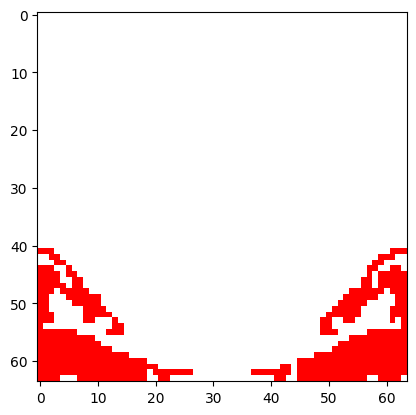

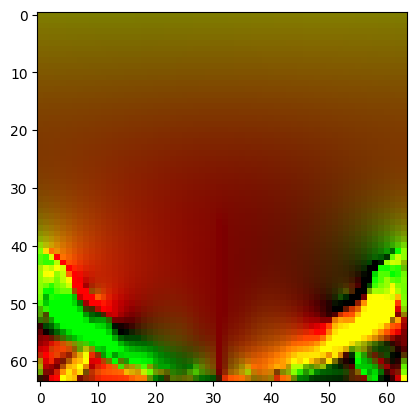

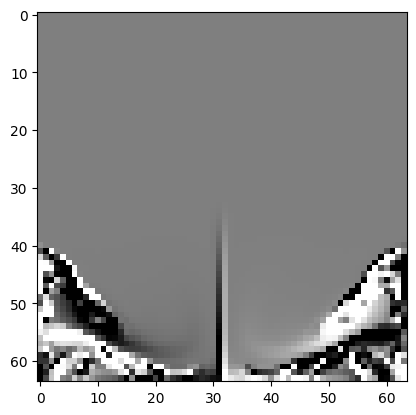

In [65]:
# dye is a 4d channel
plot(dye[int(anim_len*0.2)])
# velocity is a 2d channel
plot(velocity[int(anim_len*0.2)])
# curl is a 1d channel
plot(curl[int(anim_len*0.2)])

In [66]:
def init_image(step):
    img = np.zeros((64, 64 , n_total_channels), dtype=np.float32)
    img[:, :, :4] = rgba(dye[step])
    img[:, :, 4:6] = rgba(velocity[step])[:, :, :2]
    img[:, :, 6:7] = rgba(curl[step])[:, :, :1]
    img = tf.expand_dims(img, 0)
    return img

In [71]:
def loss_f(i, x):
    return loss_object(rgba(dye[i]), rgba(x))

def train(iterations):
    # pick a random frame from the animation
    n = np.random.randint(0,anim_len-1,size=iterations)
    j = 0
    for i in n:
        j += 1

        x = init_image(i)
        with tf.GradientTape() as g:
            
            x= model(x, 1)
            # loss is computed with the difference between the current frame and the next frame
            loss = loss_f(i+1, x) * 100
            
        gradients = g.gradient(loss, model.weights)
        gradients = [g / (tf.norm(g) + 1e-8) for g in gradients]
        optimizer.apply_gradients(zip(gradients, model.weights))

        if j % 1000 == 0:
            f, axs = plt.subplots(1, 3)
            template = 'Epoch {}, Loss: {}'
            print(template.format(j + 1, loss))
            axs[0].imshow(rgb(dye[i]))
            axs[1].imshow(rgb(x))
            axs[2].imshow(rgb(dye[i + 1]))
            plt.show()
                
    return x, loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 101, Loss: 0.004556572530418634


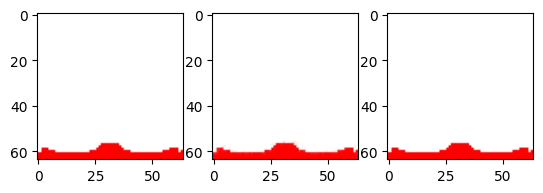

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 201, Loss: 0.057518742978572845


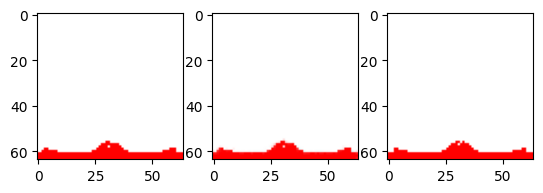

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 301, Loss: 0.046912748366594315


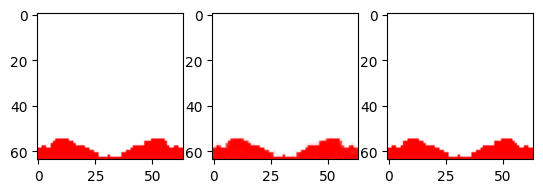

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 401, Loss: 0.48363757133483887


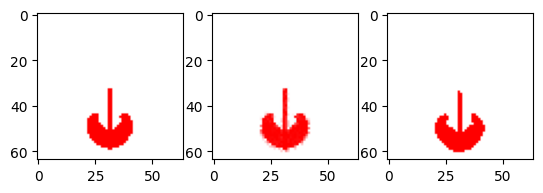

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 501, Loss: 0.09410911053419113


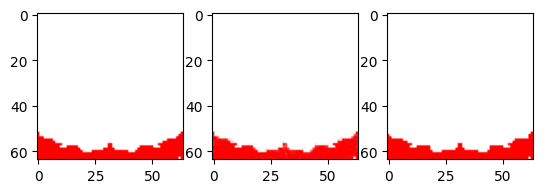

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 601, Loss: 0.01134681235998869


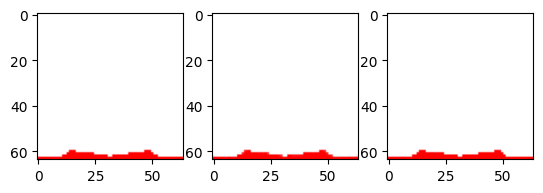

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 701, Loss: 0.6570650935173035


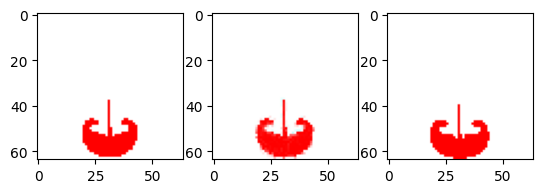

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 801, Loss: 0.4143260419368744


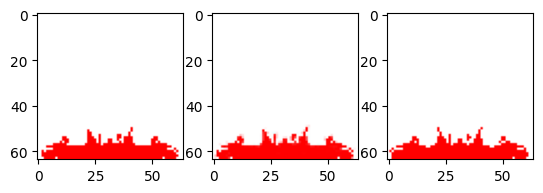

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 901, Loss: 0.15287911891937256


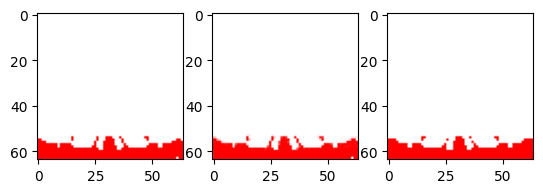

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1001, Loss: 0.4032677114009857


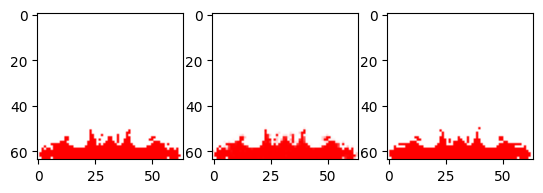

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1101, Loss: 0.027175184339284897


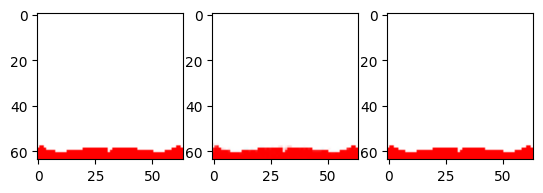

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1201, Loss: 0.044770702719688416


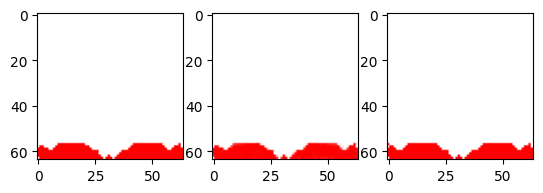

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1301, Loss: 0.6222202181816101


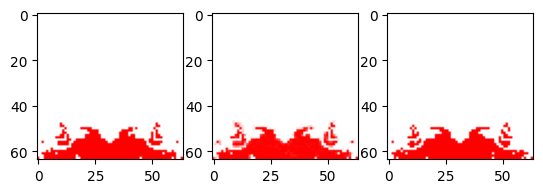

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1401, Loss: 0.6219968199729919


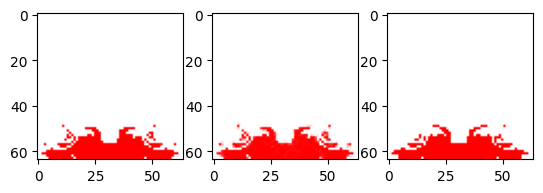

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1501, Loss: 0.0434732511639595


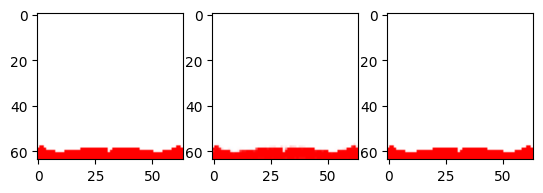

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1601, Loss: 0.044845324009656906


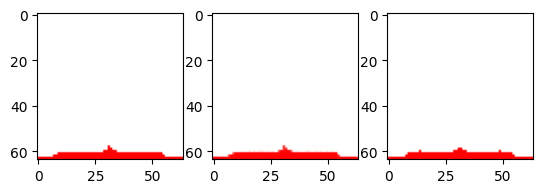

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1701, Loss: 0.02096112258732319


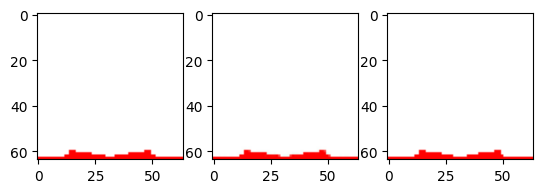

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1801, Loss: 0.04815392568707466


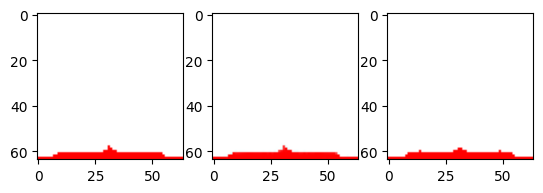

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 1901, Loss: 0.5971990823745728


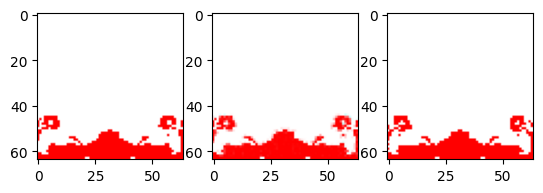

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2001, Loss: 0.6854733228683472


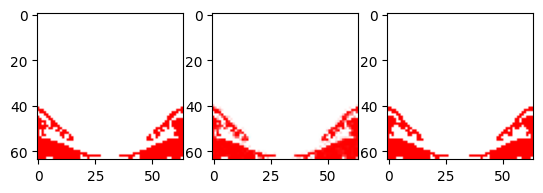

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2101, Loss: 0.021745972335338593


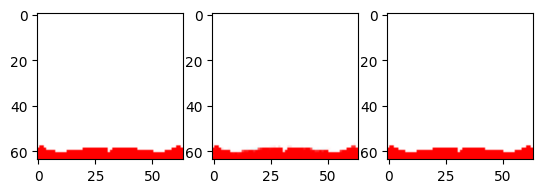

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2201, Loss: 0.5496905446052551


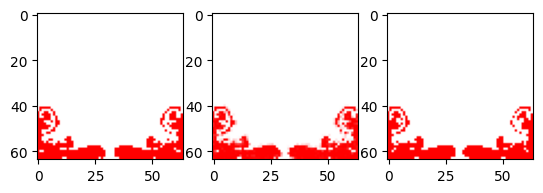

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2301, Loss: 0.027853121981024742


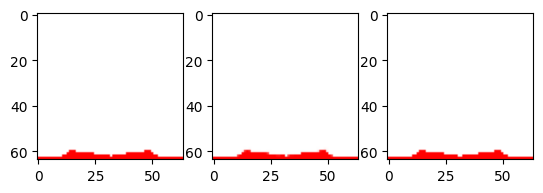

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2401, Loss: 0.08315011858940125


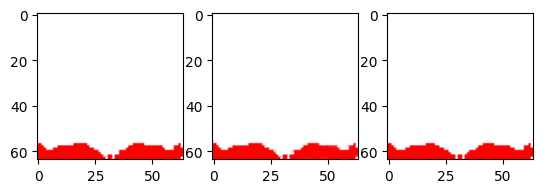

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2501, Loss: 0.01857735589146614


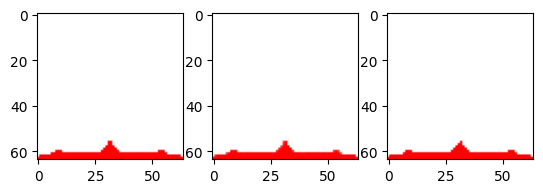

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2601, Loss: 0.7515538334846497


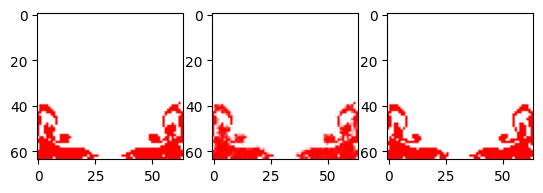

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2701, Loss: 0.7022646069526672


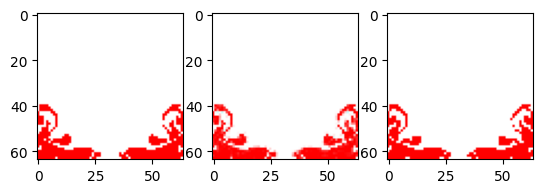

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2801, Loss: 0.08981429040431976


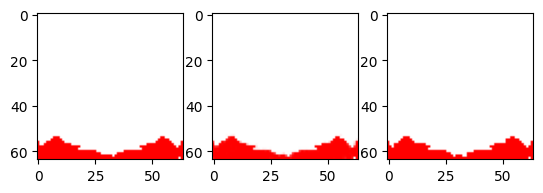

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2901, Loss: 0.527390718460083


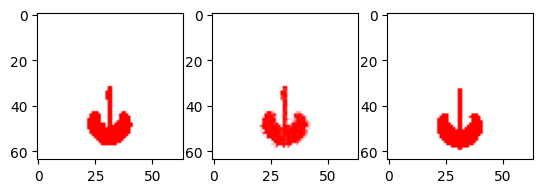

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3001, Loss: 0.5486355423927307


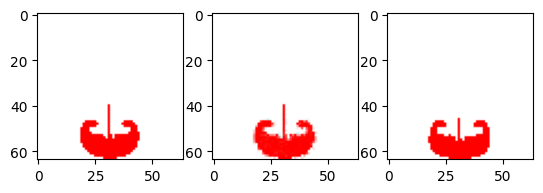

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3101, Loss: 0.02286720462143421


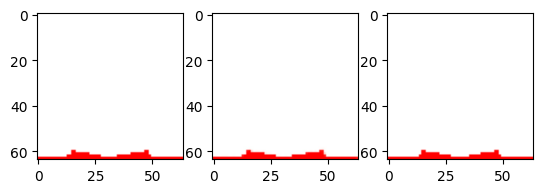

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3201, Loss: 0.08281882852315903


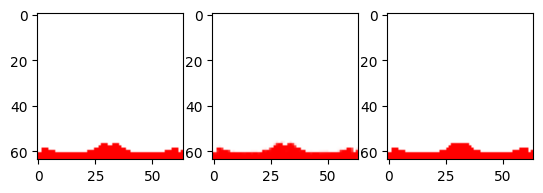

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3301, Loss: 0.05506296828389168


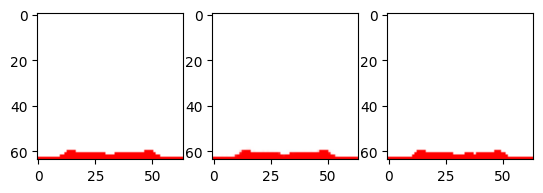

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3401, Loss: 0.05483384430408478


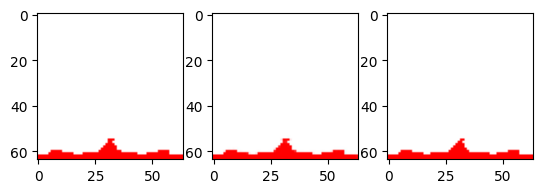

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3501, Loss: 0.021186869591474533


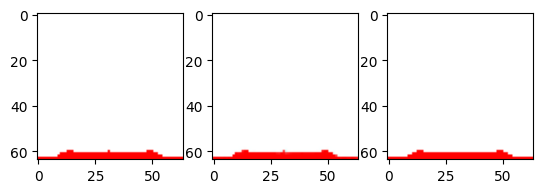

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3601, Loss: 0.8225656747817993


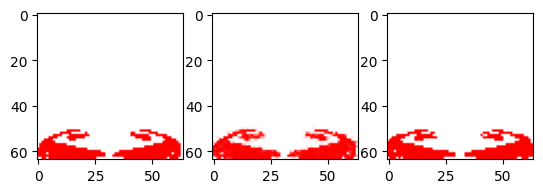

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3701, Loss: 0.7023252248764038


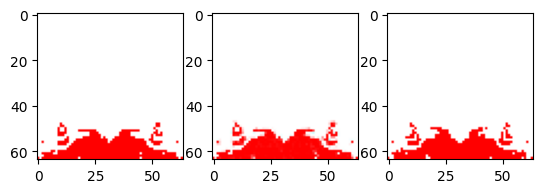

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3801, Loss: 0.06196898594498634


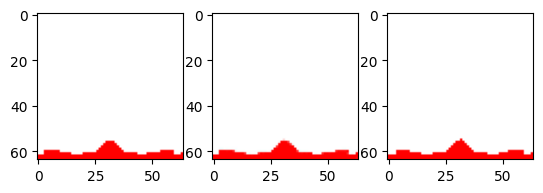

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3901, Loss: 0.35545244812965393


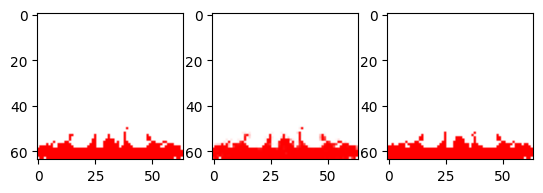

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4001, Loss: 0.8180274367332458


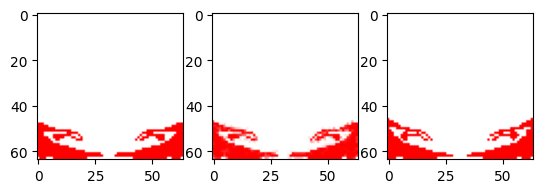

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4101, Loss: 0.03565496578812599


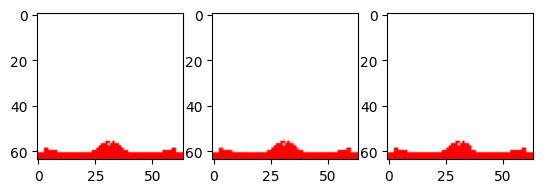

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4201, Loss: 0.39201098680496216


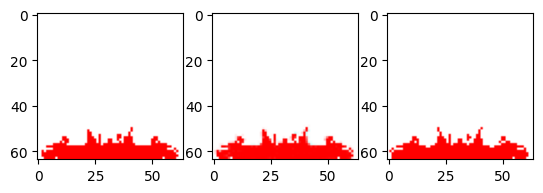

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4301, Loss: 0.7563115358352661


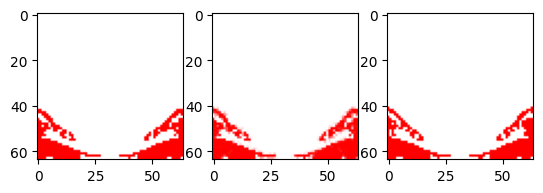

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4401, Loss: 0.020311657339334488


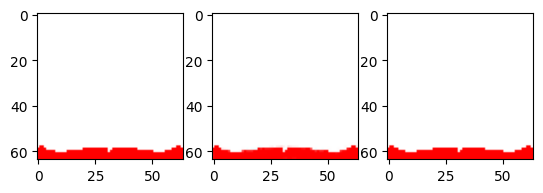

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4501, Loss: 0.028690265491604805


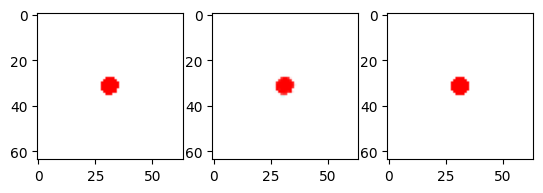

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4601, Loss: 0.4474535584449768


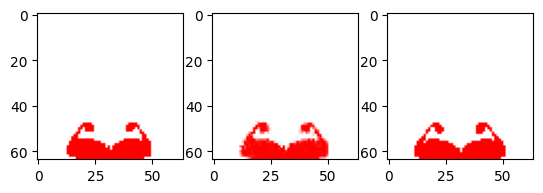

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4701, Loss: 0.041771046817302704


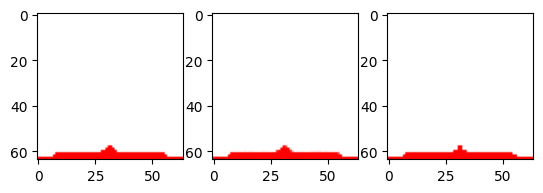

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4801, Loss: 0.5473646521568298


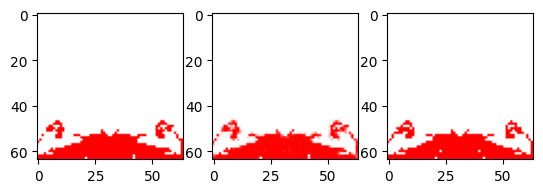

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4901, Loss: 0.5127459764480591


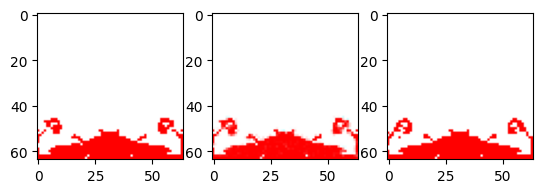

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5001, Loss: 0.036934152245521545


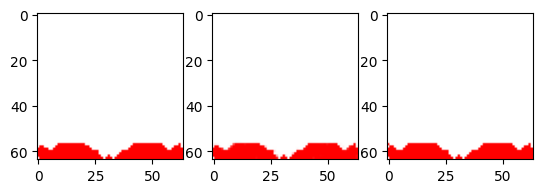

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5101, Loss: 0.5287496447563171


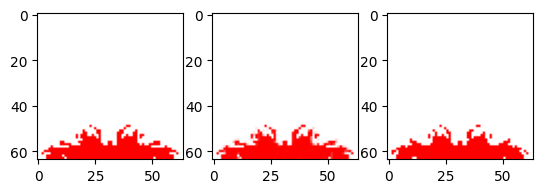

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5201, Loss: 0.4412943422794342


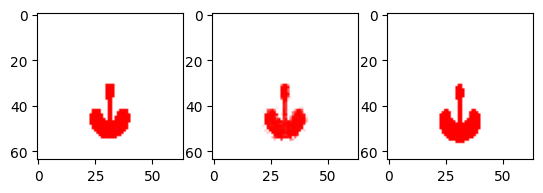

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5301, Loss: 0.15449218451976776


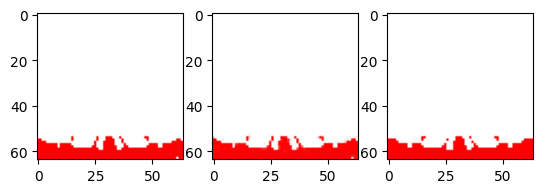

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5401, Loss: 0.055649831891059875


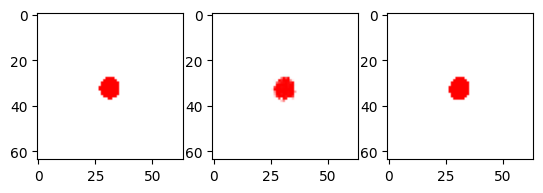

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5501, Loss: 0.08651362359523773


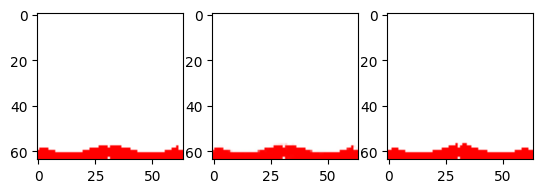

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5601, Loss: 0.04201251268386841


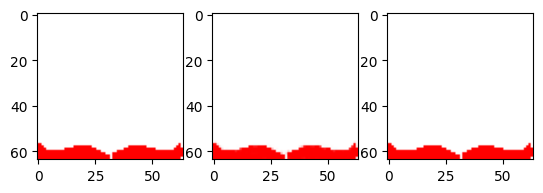

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5701, Loss: 0.15694746375083923


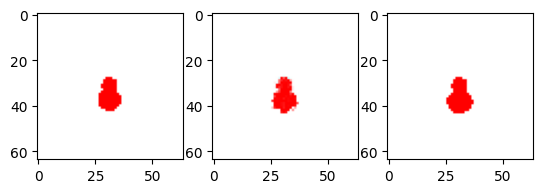

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5801, Loss: 0.03899550810456276


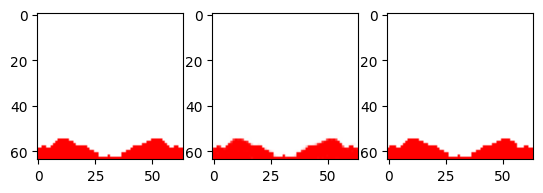

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5901, Loss: 0.6390747427940369


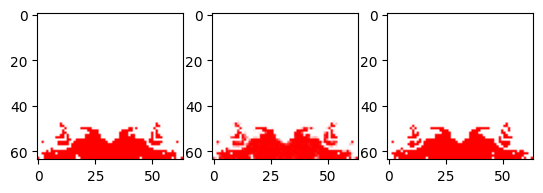

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6001, Loss: 0.6303288340568542


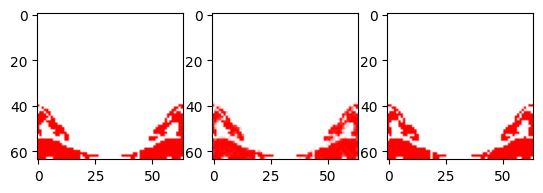

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6101, Loss: 0.6297808885574341


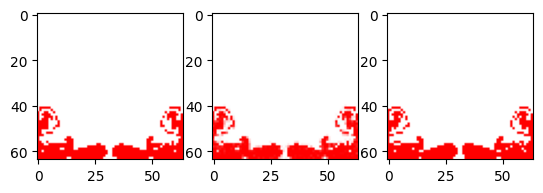

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6201, Loss: 0.08049607276916504


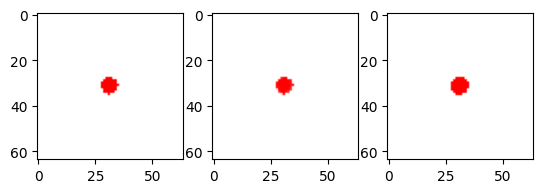

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6301, Loss: 0.30967748165130615


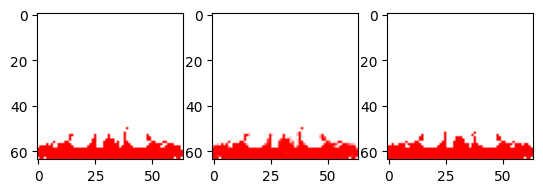

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6401, Loss: 0.7591922879219055


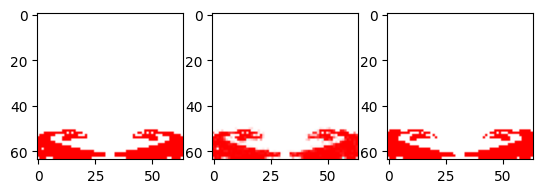

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6501, Loss: 0.6923474073410034


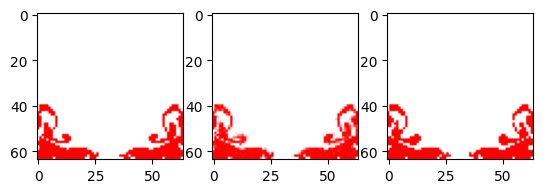

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6601, Loss: 0.08416131883859634


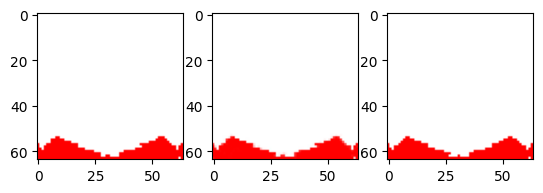

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6701, Loss: 0.07813194394111633


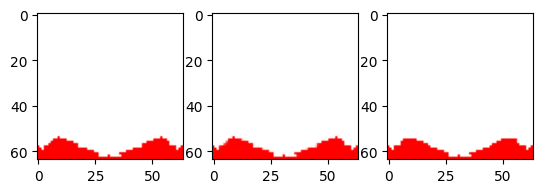

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6801, Loss: 0.3557865619659424


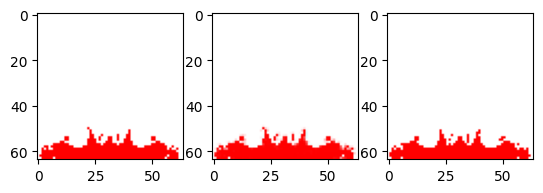

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 6901, Loss: 0.24790875613689423


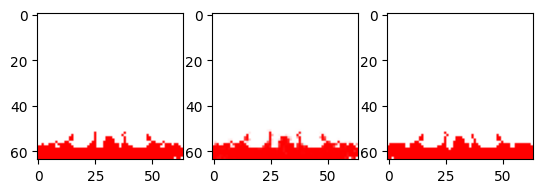

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7001, Loss: 0.14522631466388702


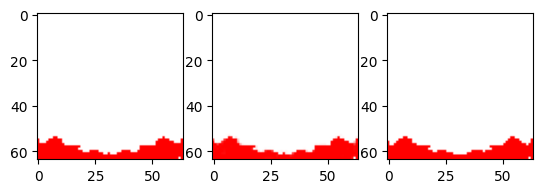

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7101, Loss: 0.656392514705658


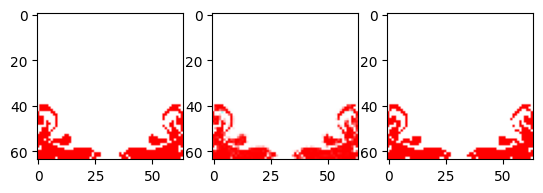

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7201, Loss: 0.04945269972085953


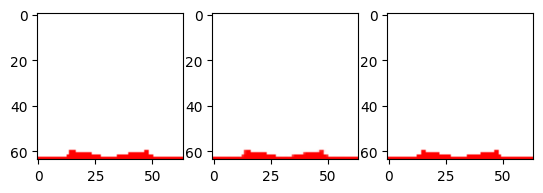

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7301, Loss: 0.6512320637702942


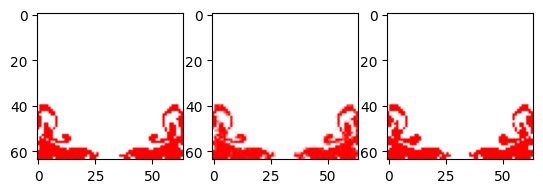

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7401, Loss: 0.48284685611724854


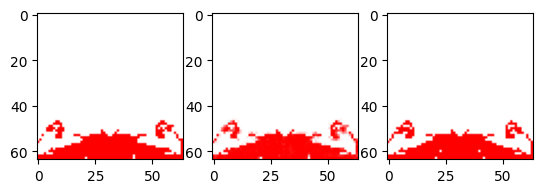

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7501, Loss: 0.7669447660446167


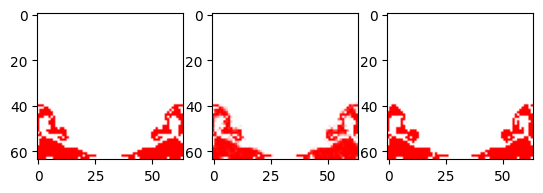

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7601, Loss: 0.5741679072380066


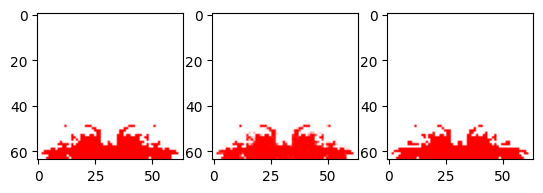

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7701, Loss: 0.368987113237381


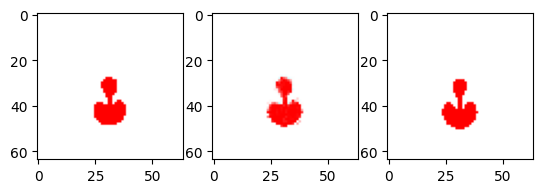

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7801, Loss: 0.3725608289241791


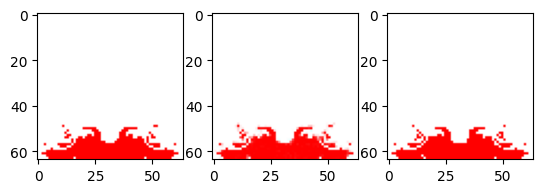

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 7901, Loss: 0.11070714890956879


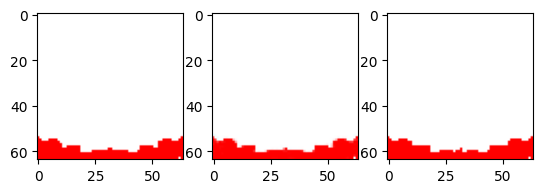

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8001, Loss: 0.5601938962936401


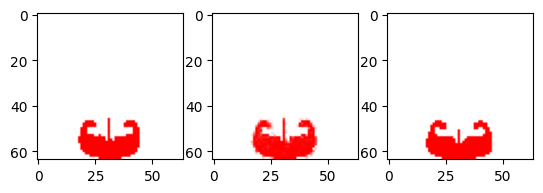

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8101, Loss: 0.08339046686887741


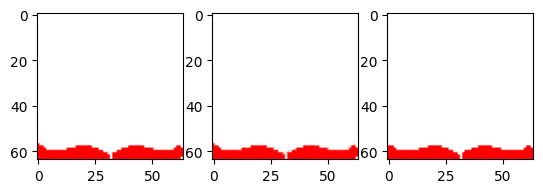

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8201, Loss: 0.7011567950248718


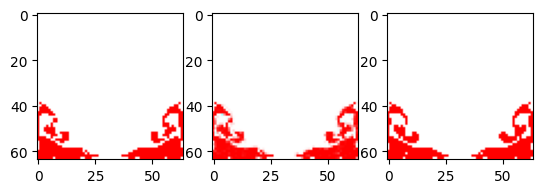

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8301, Loss: 0.045805614441633224


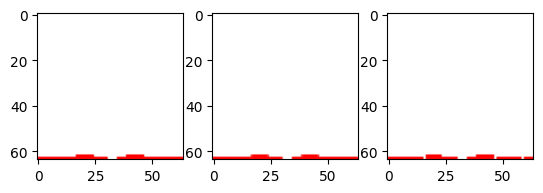

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8401, Loss: 0.19421282410621643


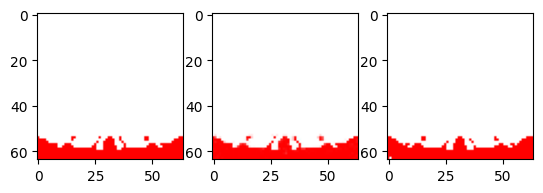

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8501, Loss: 0.04612010717391968


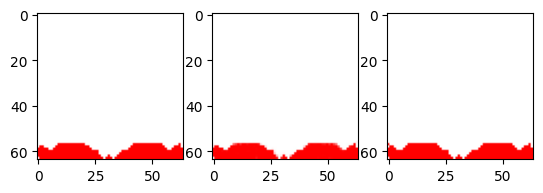

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8601, Loss: 0.06598715484142303


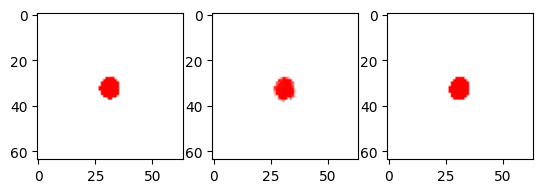

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8701, Loss: 0.615128219127655


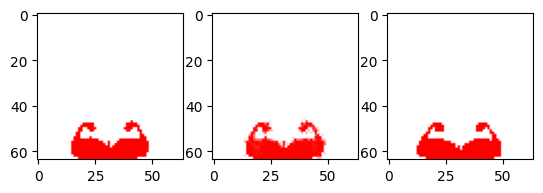

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8801, Loss: 0.34080493450164795


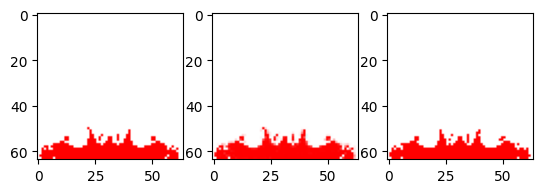

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 8901, Loss: 0.5767639875411987


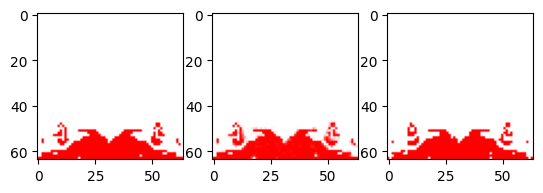

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9001, Loss: 0.05758035555481911


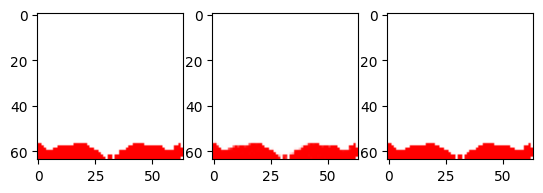

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9101, Loss: 0.3352310061454773


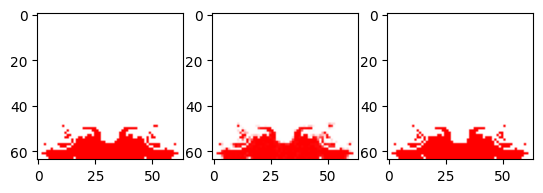

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9201, Loss: 0.13290292024612427


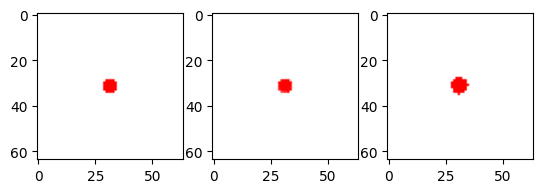

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9301, Loss: 0.43942663073539734


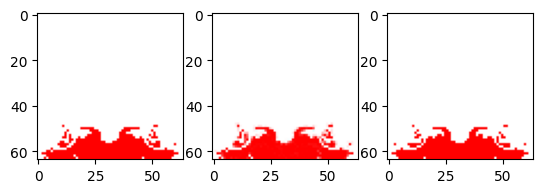

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9401, Loss: 0.7715428471565247


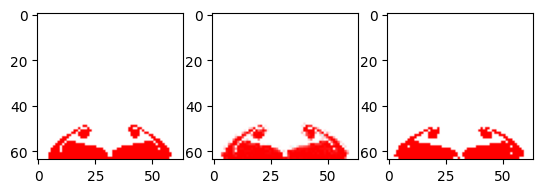

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9501, Loss: 0.2142712026834488


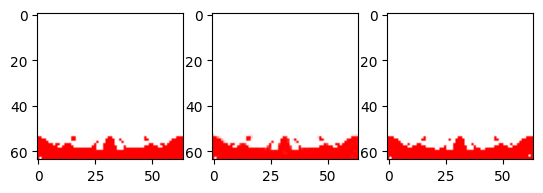

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9601, Loss: 0.036235276609659195


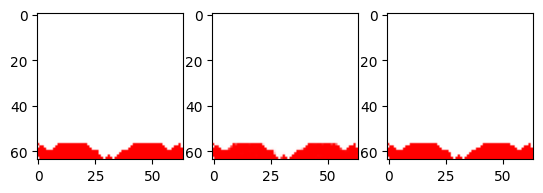

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9701, Loss: 0.18562157452106476


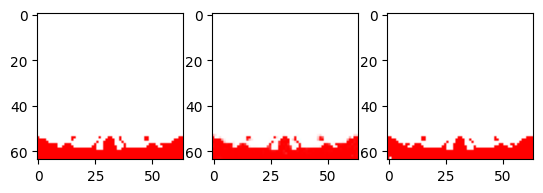

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9801, Loss: 0.09620288759469986


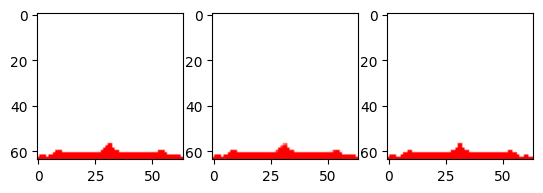

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 9901, Loss: 0.07841315865516663


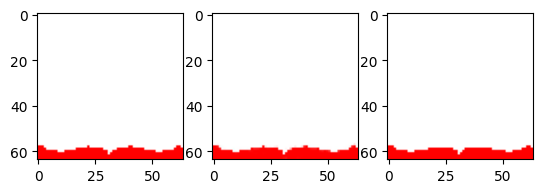

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 10001, Loss: 0.02962157316505909


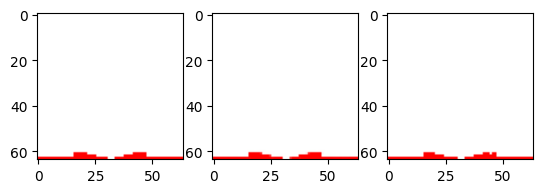

(<tf.Tensor: shape=(1, 64, 64, 7), dtype=float32, numpy=
 array([[[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          ...,
          [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [ 0.0000000e+00, -0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00]],
 
         [[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
            0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
          [-0.0000000e+00, -0.0000000e+00, -0.0000000e+00

In [72]:
train(10000)

In [244]:
model.save("testModel")

INFO:tensorflow:Assets written to: testModel/assets


INFO:tensorflow:Assets written to: testModel/assets


In [ ]:

def predict(init, iterations):
    x = init
    for i in range(iterations): 
        x= model(x, 1)
           

In [15]:
#@title TensorFlow.js Demo {run:"auto", vertical-output: true}
#@markdown Select "CHECKPOINT" model to load the checkpoint created by running cells from the "Training" section of this notebook
import IPython.display

data_js = '''
  window.GRAPH_URL = URL.createObjectURL(new Blob([`%s`], {type: 'application/json'}));
'''%(model)

display(IPython.display.Javascript(data_js))

IPython.display.HTML('''
<script src="https://cdn.jsdelivr.net/npm/@tensorflow/tfjs@2.3.0/dist/tf.min.js"></script>

<canvas id='canvas' style="border: 1px solid black; image-rendering: pixelated;"></canvas>

<script>
  "use strict";
  
  const sleep = (ms)=>new Promise(resolve => setTimeout(resolve, ms));

  const parseConsts = model_graph=>{
    const dtypes = {'DT_INT32':['int32', 'intVal', Int32Array],
                    'DT_FLOAT':['float32', 'floatVal', Float32Array]};
    
    const consts = {};
    model_graph.modelTopology.node.filter(n=>n.op=='Const').forEach((node=>{
      const v = node.attr.value.tensor;
      const [dtype, field, arrayType] = dtypes[v.dtype];
      if (!v.tensorShape.dim) {
        consts[node.name] = [tf.scalar(v[field][0], dtype)];
      } else {
        // if there is a 0-length dimension, the exported graph json lacks "size"
        const shape = v.tensorShape.dim.map(d=>(!d.size) ? 0 : parseInt(d.size));
        let arr;
        if (v.tensorContent) {
          const data = atob(v.tensorContent);
          const buf = new Uint8Array(data.length);
          for (var i=0; i<data.length; ++i) {
            buf[i] = data.charCodeAt(i);
          }
          arr = new arrayType(buf.buffer);
        } else {
          const size = shape.reduce((a, b)=>a*b);
          arr = new arrayType(size);
          if (size) {
            arr.fill(v[field][0]);
          }
        }
        consts[node.name] = [tf.tensor(arr, shape, dtype)];
      }
    }));
    return consts;
  }
  
  const run = async ()=>{
    const r = await fetch(GRAPH_URL);
    const consts = parseConsts(await r.json());
    
    const model = await tf.loadGraphModel(GRAPH_URL);
    Object.assign(model.weights, consts);
    
    let seed = new Array(16).fill(0).map((x, i)=>i<3?0:1);
    seed = tf.tensor(seed, [1, 1, 1, 16]);
    
    const D = 96;
    const initState = tf.tidy(()=>{
      const D2 = D/2;
      const a = seed.pad([[0, 0], [D2-1, D2], [D2-1, D2], [0,0]]);
      return a;
    });
    
    const state = tf.variable(initState);
    const [_, h, w, ch] = state.shape;
    
    const damage = (x, y, r)=>{
      tf.tidy(()=>{
        const rx = tf.range(0, w).sub(x).div(r).square().expandDims(0);
        const ry = tf.range(0, h).sub(y).div(r).square().expandDims(1);
        const mask = rx.add(ry).greater(1.0).expandDims(2);
        state.assign(state.mul(mask));
      });
    }
    
    const plantSeed = (x, y)=>{
      const x2 = w-x-seed.shape[2];
      const y2 = h-y-seed.shape[1];
      if (x<0 || x2<0 || y2<0 || y2<0)
        return;
      tf.tidy(()=>{
        const a = seed.pad([[0, 0], [y, y2], [x, x2], [0,0]]);
        state.assign(state.add(a));
      });
    }
    
    const scale = 4;
    
    const canvas = document.getElementById('canvas');
    const ctx = canvas.getContext('2d');
    canvas.width = w;
    canvas.height = h;
    canvas.style.width = `${w*scale}px`;
    canvas.style.height = `${h*scale}px`;
    
    canvas.onmousedown = e=>{
      const x = Math.floor(e.clientX/scale);
        const y = Math.floor(e.clientY/scale);
        if (e.buttons == 1) {
          if (e.shiftKey) {
            plantSeed(x, y);  
          } else {
            damage(x, y, 8);
          }
        }
    }
    canvas.onmousemove = e=>{
      const x = Math.floor(e.clientX/scale);
      const y = Math.floor(e.clientY/scale);
      if (e.buttons == 1 && !e.shiftKey) {
        damage(x, y, 8);
      }
    }

    function step() {
      tf.tidy(()=>{
        state.assign(model.execute(
            {x:state, fire_rate:tf.tensor(0.5),
            angle:tf.tensor(0.0), step_size:tf.tensor(1.0)}, ['Identity']));
      });
    }

    function render() {
      step();

      const imageData = tf.tidy(()=>{
        const rgba = state.slice([0, 0, 0, 0], [-1, -1, -1, 4]);
        const a = state.slice([0, 0, 0, 3], [-1, -1, -1, 1]);
        const img = tf.tensor(1.0).sub(a).add(rgba).mul(255);
        const rgbaBytes = new Uint8ClampedArray(img.dataSync());
        return new ImageData(rgbaBytes, w, h);
      });
      ctx.putImageData(imageData, 0, 0);

      requestAnimationFrame(render);
    }
    render();
  }
  run();
  
</script>
''')

<IPython.core.display.Javascript object>